Max Total_EV in training data (unscaled): 9173.00
Max Total_EV in training data (scaled): 0.00917
Lower bound for m (scaled): 0.00926
Upper bound for m (scaled): 0.04587

Fitted parameters (using L-BFGS-B with regularization_strength=0.001):
p = 0.03437, q = 0.00001, m = 0.00926 (scaled)
Optimization success: True
Optimization message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL

Training Metrics:
MAE = 1184.55, RMSE = 1622.40, MAPE = 21.98%
Testing Metrics:
MAE = 2721.76, RMSE = 2925.15, MAPE = 23.13%


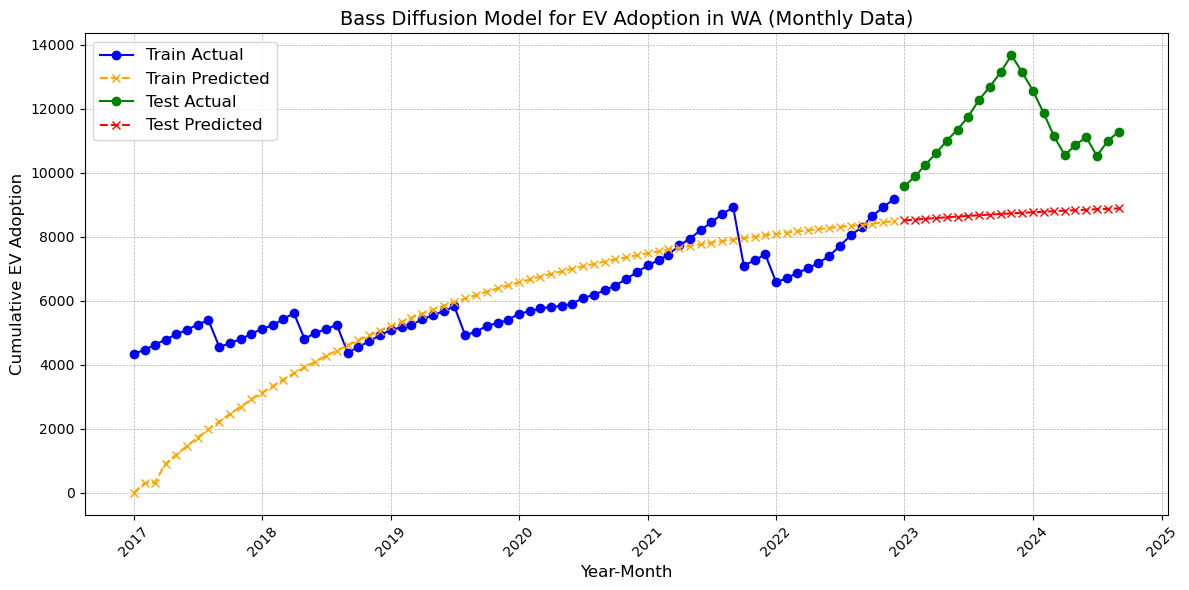

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Data Loading and Preprocessing
ev_df = pd.read_csv("C:\\Users\\shami\\Downloads\\Electric_Vehicle_Population_Size_History_By_County_20241018.csv")

# Fill missing 'County' and 'State' values with a placeholder like "Unknown"
ev_df['County'].fillna("Unknown", inplace=True)
ev_df['State'].fillna("Unknown", inplace=True)

# Convert 'Electric Vehicle (EV) Total' to numeric and drop rows with invalid values
ev_df['Total_EV'] = pd.to_numeric(ev_df['Electric Vehicle (EV) Total'], errors='coerce')
ev_df = ev_df.dropna(subset=['Total_EV'])

# Step 2: Convert 'Year' and 'Month' columns into Year-Month format for monthly aggregation
ev_df['Year-Month'] = pd.to_datetime(ev_df['Year'].astype(str) + '-' + ev_df['Month'], format='%Y-%B')

# Step 3: Aggregate the data by State and Year-Month (monthly aggregation)
ev_state_month = ev_df.groupby(['State', 'Year-Month'])['Total_EV'].sum().reset_index()

# Step 4: Choose a state to model
state_name = 'WA' # Changed state_name to 'WA'
state_data = ev_state_month[ev_state_month['State'] == state_name].sort_values('Year-Month').copy()

# Step 5: Create the time variable 't' for months since the start of the dataset
state_data['t'] = (state_data['Year-Month'] - state_data['Year-Month'].min()) / np.timedelta64(1, 'D')
state_data['t'] = state_data['t'].astype(int) // 30

# Step 6: Train-test split by years (80% train, 20% test)
years = state_data['Year-Month'].dt.year.unique()
split_idx = int(len(years) * 0.8)
train_years = years[:split_idx]
test_years = years[split_idx:]

train_df = state_data[state_data['Year-Month'].dt.year.isin(train_years)].copy()
test_df = state_data[state_data['Year-Month'].dt.year.isin(test_years)].copy()

# Step 7: Scale Total_EV to prevent numerical issues during optimization
scale_factor = 1e6 # Adjust this based on the typical magnitude of your EV totals
train_df['Total_EV_scaled'] = train_df['Total_EV'] / scale_factor
test_df['Total_EV_scaled'] = test_df['Total_EV'] / scale_factor

# Step 8: Prepare data arrays for fitting
t_train = train_df['t'].values
actual_train = train_df['Total_EV_scaled'].values
t_test = test_df['t'].values
actual_test = test_df['Total_EV_scaled'].values

# --- Debugging Information ---
print(f"Max Total_EV in training data (unscaled): {train_df['Total_EV'].max():.2f}")
print(f"Max Total_EV in training data (scaled): {actual_train.max():.5f}")

# Step 9: Stable Bass model function (modified for monthly data)
def bass_model(t, p, q, m):
    val = -(p + q) * t
    exp_comp = np.exp(np.clip(val, -700, 700))
    denominator = 1 + (q / p) * exp_comp
    denominator = np.clip(denominator, 1e-10, None)
    return m * (1 - exp_comp) / denominator

# Step 10: Objective function for optimization (Root Mean Squared Error)
def objective(params, t, actual, regularization_strength):
    p, q, m = params

    if not (1e-6 <= p <= 1 and 1e-6 <= q <= 1 and m > 0):
        return np.inf

    reg_term = regularization_strength * (p**2 + q**2)
    pred = bass_model(t, p, q, m)

    if np.any(np.isnan(pred)) or np.any(np.isinf(pred)):
        return np.inf

    return np.sqrt(np.mean((actual - pred) ** 2)) + reg_term

# Step 11: Initial parameter guesses and bounds
init_params = [0.03, 0.2, actual_train.max() * 1.5]
m_lower_bound = actual_train.max() * 1.01
m_upper_bound = actual_train.max() * 5
bounds = [(1e-5, 1), (1e-5, 1), (m_lower_bound, m_upper_bound)]

print(f"Lower bound for m (scaled): {m_lower_bound:.5f}")
print(f"Upper bound for m (scaled): {m_upper_bound:.5f}")

# Step 12: Perform optimization to fit parameters on training data
optimization_method = 'L-BFGS-B' # Try 'Powell', 'SLSQP', 'TNC'
regularization_strength = 0.001 # Reduced regularization for potentially better fit of p, q

res = minimize(objective, init_params, args=(t_train, actual_train, regularization_strength),
               bounds=bounds, method=optimization_method, options={'maxiter': 1000})
p_opt, q_opt, m_opt = res.x

print(f"\nFitted parameters (using {optimization_method} with regularization_strength={regularization_strength}):")
print(f"p = {p_opt:.5f}, q = {q_opt:.5f}, m = {m_opt:.5f} (scaled)")
print(f"Optimization success: {res.success}")
print(f"Optimization message: {res.message}")

# Step 13: Predict on training and test sets using the optimized parameters (scaled predictions)
train_pred_scaled = bass_model(t_train, p_opt, q_opt, m_opt)
test_pred_scaled = bass_model(t_test, p_opt, q_opt, m_opt)

# Step 14: Scale predictions back to original scale
train_pred = train_pred_scaled * scale_factor
test_pred = test_pred_scaled * scale_factor

# Step 15: Calculate performance metrics on original scale
def calc_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    actual_copy = actual.copy()
    actual_copy[actual_copy == 0] = 1e-10
    mape = np.mean(np.abs((actual - predicted) / actual_copy)) * 100
    return mae, rmse, mape

train_mae, train_rmse, train_mape = calc_metrics(train_df['Total_EV'], train_pred)
test_mae, test_rmse, test_mape = calc_metrics(test_df['Total_EV'], test_pred)

print(f"\nTraining Metrics:\nMAE = {train_mae:.2f}, RMSE = {train_rmse:.2f}, MAPE = {train_mape:.2f}%")
print(f"Testing Metrics:\nMAE = {test_mae:.2f}, RMSE = {test_rmse:.2f}, MAPE = {test_mape:.2f}%")

# Step 16: Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(train_df['Year-Month'], train_df['Total_EV'], 'o-', label='Train Actual', color='blue', markersize=6)
plt.plot(train_df['Year-Month'], train_pred, 'x--', label='Train Predicted', color='orange', markersize=6)
plt.plot(test_df['Year-Month'], test_df['Total_EV'], 'o-', label='Test Actual', color='green', markersize=6)
plt.plot(test_df['Year-Month'], test_pred, 'x--', label='Test Predicted', color='red', markersize=6)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Cumulative EV Adoption', fontsize=12)
plt.title(f'Bass Diffusion Model for EV Adoption in {state_name} (Monthly Data)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Max Total_EV in training data (unscaled): 128.00
Max Total_EV in training data (scaled): 0.00013
Lower bound for m (scaled): 0.00013
Upper bound for m (scaled): 0.00064

Fitted parameters (using L-BFGS-B with regularization_strength=0.001):
p = 0.00178, q = 0.16268, m = 0.00013 (scaled)
Optimization success: True
Optimization message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

Training Metrics:
MAE = 22.48, RMSE = 24.59, MAPE = 38.80%
Testing Metrics:
MAE = 9.45, RMSE = 10.47, MAPE = 7.03%


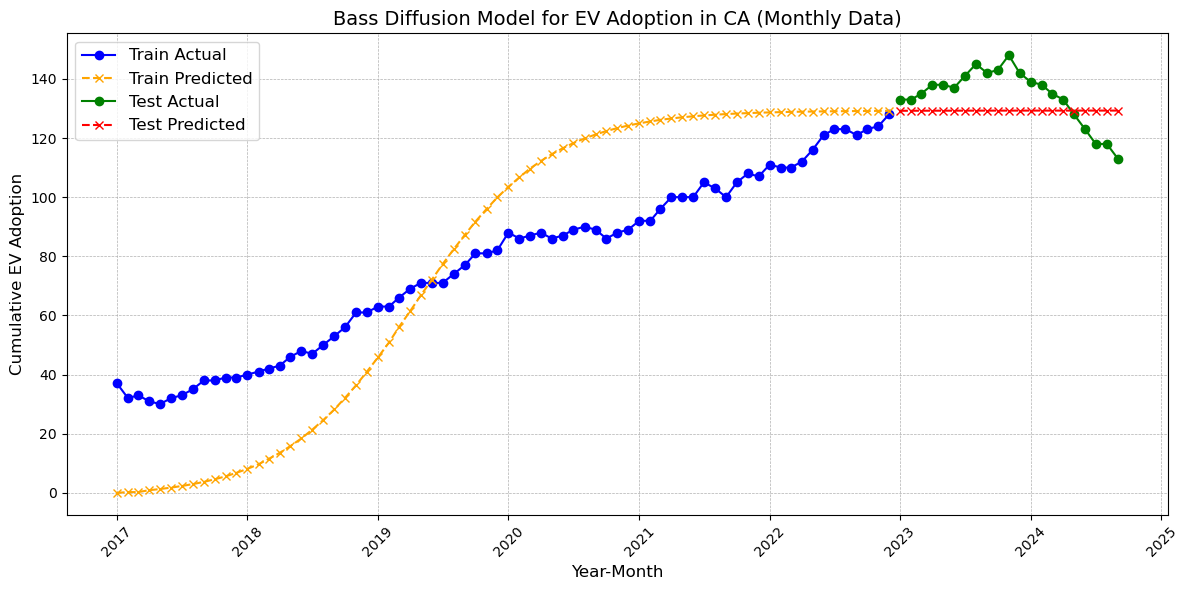

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Data Loading and Preprocessing
ev_df = pd.read_csv("C:\\Users\\shami\\Downloads\\Electric_Vehicle_Population_Size_History_By_County_20241018.csv")

# Fill missing 'County' and 'State' values with a placeholder like "Unknown"
ev_df['County'].fillna("Unknown", inplace=True)
ev_df['State'].fillna("Unknown", inplace=True)

# Convert 'Electric Vehicle (EV) Total' to numeric and drop rows with invalid values
ev_df['Total_EV'] = pd.to_numeric(ev_df['Electric Vehicle (EV) Total'], errors='coerce')
ev_df = ev_df.dropna(subset=['Total_EV'])

# Step 2: Convert 'Year' and 'Month' columns into Year-Month format for monthly aggregation
ev_df['Year-Month'] = pd.to_datetime(ev_df['Year'].astype(str) + '-' + ev_df['Month'], format='%Y-%B')

# Step 3: Aggregate the data by State and Year-Month (monthly aggregation)
ev_state_month = ev_df.groupby(['State', 'Year-Month'])['Total_EV'].sum().reset_index()

# Step 4: Choose a state to model
state_name = 'CA'
state_data = ev_state_month[ev_state_month['State'] == state_name].sort_values('Year-Month').copy()

# Step 5: Create the time variable 't' for months since the start of the dataset
state_data['t'] = (state_data['Year-Month'] - state_data['Year-Month'].min()) / np.timedelta64(1, 'D')
state_data['t'] = state_data['t'].astype(int) // 30

# Step 6: Train-test split by years (80% train, 20% test)
years = state_data['Year-Month'].dt.year.unique()
split_idx = int(len(years) * 0.8)
train_years = years[:split_idx]
test_years = years[split_idx:]

train_df = state_data[state_data['Year-Month'].dt.year.isin(train_years)].copy()
test_df = state_data[state_data['Year-Month'].dt.year.isin(test_years)].copy()

# Step 7: Scale Total_EV to prevent numerical issues during optimization
scale_factor = 1e6 # Adjust this based on the typical magnitude of your EV totals
train_df['Total_EV_scaled'] = train_df['Total_EV'] / scale_factor
test_df['Total_EV_scaled'] = test_df['Total_EV'] / scale_factor

# Step 8: Prepare data arrays for fitting
t_train = train_df['t'].values
actual_train = train_df['Total_EV_scaled'].values
t_test = test_df['t'].values
actual_test = test_df['Total_EV_scaled'].values

# --- Debugging Information ---
print(f"Max Total_EV in training data (unscaled): {train_df['Total_EV'].max():.2f}")
print(f"Max Total_EV in training data (scaled): {actual_train.max():.5f}")

# Step 9: Stable Bass model function (modified for monthly data)
def bass_model(t, p, q, m):
    val = -(p + q) * t
    exp_comp = np.exp(np.clip(val, -700, 700))
    denominator = 1 + (q / p) * exp_comp
    denominator = np.clip(denominator, 1e-10, None)
    return m * (1 - exp_comp) / denominator

# Step 10: Objective function for optimization (Root Mean Squared Error)
def objective(params, t, actual, regularization_strength):
    p, q, m = params

    if not (1e-6 <= p <= 1 and 1e-6 <= q <= 1 and m > 0):
        return np.inf

    reg_term = regularization_strength * (p**2 + q**2)
    pred = bass_model(t, p, q, m)

    if np.any(np.isnan(pred)) or np.any(np.isinf(pred)):
        return np.inf

    return np.sqrt(np.mean((actual - pred) ** 2)) + reg_term

# Step 11: Initial parameter guesses and bounds
init_params = [0.03, 0.2, actual_train.max() * 1.5]
m_lower_bound = actual_train.max() * 1.01
m_upper_bound = actual_train.max() * 5
bounds = [(1e-5, 1), (1e-5, 1), (m_lower_bound, m_upper_bound)]

print(f"Lower bound for m (scaled): {m_lower_bound:.5f}")
print(f"Upper bound for m (scaled): {m_upper_bound:.5f}")

# Step 12: Perform optimization to fit parameters on training data
optimization_method = 'L-BFGS-B' # Try 'Powell', 'SLSQP', 'TNC'
regularization_strength = 0.001 # Reduced regularization for potentially better fit of p, q

res = minimize(objective, init_params, args=(t_train, actual_train, regularization_strength),
               bounds=bounds, method=optimization_method, options={'maxiter': 1000})
p_opt, q_opt, m_opt = res.x

print(f"\nFitted parameters (using {optimization_method} with regularization_strength={regularization_strength}):")
print(f"p = {p_opt:.5f}, q = {q_opt:.5f}, m = {m_opt:.5f} (scaled)")
print(f"Optimization success: {res.success}")
print(f"Optimization message: {res.message}")

# Step 13: Predict on training and test sets using the optimized parameters (scaled predictions)
train_pred_scaled = bass_model(t_train, p_opt, q_opt, m_opt)
test_pred_scaled = bass_model(t_test, p_opt, q_opt, m_opt)

# Step 14: Scale predictions back to original scale
train_pred = train_pred_scaled * scale_factor
test_pred = test_pred_scaled * scale_factor

# Step 15: Calculate performance metrics on original scale
def calc_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    actual_copy = actual.copy()
    actual_copy[actual_copy == 0] = 1e-10
    mape = np.mean(np.abs((actual - predicted) / actual_copy)) * 100
    return mae, rmse, mape

train_mae, train_rmse, train_mape = calc_metrics(train_df['Total_EV'], train_pred)
test_mae, test_rmse, test_mape = calc_metrics(test_df['Total_EV'], test_pred)

print(f"\nTraining Metrics:\nMAE = {train_mae:.2f}, RMSE = {train_rmse:.2f}, MAPE = {train_mape:.2f}%")
print(f"Testing Metrics:\nMAE = {test_mae:.2f}, RMSE = {test_rmse:.2f}, MAPE = {test_mape:.2f}%")

# Step 16: Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(train_df['Year-Month'], train_df['Total_EV'], 'o-', label='Train Actual', color='blue', markersize=6)
plt.plot(train_df['Year-Month'], train_pred, 'x--', label='Train Predicted', color='orange', markersize=6)
plt.plot(test_df['Year-Month'], test_df['Total_EV'], 'o-', label='Test Actual', color='green', markersize=6)
plt.plot(test_df['Year-Month'], test_pred, 'x--', label='Test Predicted', color='red', markersize=6)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Cumulative EV Adoption', fontsize=12)
plt.title(f'Bass Diffusion Model for EV Adoption in {state_name} (Monthly Data)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()